In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
base_dir = "/home/aldec/data/random_stuff/KaggleFun/HealthAnalytics"
df_train = pd.read_csv(os.path.join(base_dir,"pro_train.csv"))
df_test = pd.read_csv(os.path.join(base_dir,"pro_test.csv"))
df_train.head(5)

,Unnamed: 0,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,231676,0,7,1,4,2,1,2,2.0,8.0,0,1,4,4,6247.0,2
1,166821,0,7,1,2,3,3,2,1.0,2.0,0,1,6,6,8000.0,10
2,70566,1,2,1,2,3,2,3,3.0,7.0,0,2,3,2,4987.0,1
3,197982,1,2,1,2,2,1,3,3.0,14.0,1,1,3,6,7210.0,6
4,280389,3,13,1,4,3,2,1,2.0,8.0,2,1,2,4,3178.0,5


In [2]:
df_y = df_train.Stay
df_train = df_train.drop("Stay", axis = 1)

In [3]:
df_test_y = df_test.Stay
df_test = df_test.drop("Stay", axis=1)

In [4]:
from sklearn.preprocessing import StandardScaler

num_attribs = ["Available Extra Rooms in Hospital", "Bed Grade", "Visitors with Patient", "Admission_Deposit"]
cat_attribs = ["Hospital_type_code", "City_Code_Hospital", "Hospital_region_code", "Department", "Ward_Type", "Ward_Facility_Code", "City_Code_Patient", "Type of Admission"]

scaler = StandardScaler()

df_train[num_attribs] = scaler.fit_transform(df_train[num_attribs])
df_test[num_attribs] = scaler.fit_transform(df_test[num_attribs])

In [5]:
def eva(model):
    y0 = model.predict(df_train)
    correct = 0
    df_y0 = df_y
    for i in range(len(y0)):
        if y0[i] == df_y0[i]: 
            correct += 1
    a1 = correct / len(df_train)
    
    y0 = model.predict(df_test)
    correct = 0
    df_y0 = df_test_y
    for i in range(len(y0)):
        if y0[i] == df_y0[i]: 
            correct += 1
    a2 = correct / len(df_test)
    
    return a1, a2

In [6]:
from xgboost import XGBClassifier
learning_rate = 0.5
max_depth = 5
n_estimators = 200

for learning_rate in [0.3,0.7]:
    for max_depth in [8,10]:
        for n_estimators in [200,250]:
            xgb_model=XGBClassifier(objective="multi:softmax", eval_metric="merror", learning_rate=learning_rate,min_child_weight=1, max_depth=max_depth, n_estimators=n_estimators, use_label_encoder=False)
            xgb_model.fit(df_train,df_y)
            print("LR: {}, Depth: {}, Estimators: {}".format(learning_rate, max_depth, n_estimators))
            a1, a2 = eva(xgb_model)
            print("Acc: {:.04f} || Test Acc: {:.04f}".format(a1,a2))
            print()
            del xgb_model

LR: 0.3, Depth: 8, Estimators: 200


/home/aldec/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Acc: 0.6020 || Test Acc: 0.4197

LR: 0.3, Depth: 8, Estimators: 250
Acc: 0.6303 || Test Acc: 0.4197

LR: 0.3, Depth: 10, Estimators: 200
Acc: 0.7387 || Test Acc: 0.4172

LR: 0.3, Depth: 10, Estimators: 250
Acc: 0.7751 || Test Acc: 0.4159

LR: 0.7, Depth: 8, Estimators: 200
Acc: 0.7294 || Test Acc: 0.4031

LR: 0.7, Depth: 8, Estimators: 250
Acc: 0.7714 || Test Acc: 0.4014

LR: 0.7, Depth: 10, Estimators: 200
Acc: 0.8943 || Test Acc: 0.3967

LR: 0.7, Depth: 10, Estimators: 250
Acc: 0.9282 || Test Acc: 0.3953



In [7]:
xgb_model=XGBClassifier(objective="multi:softmax",learning_rate=0.3,min_child_weight=1, max_depth=8, n_estimators=250)
xgb_model.fit(df_train,df_y)
print("Train Complete, Evaluating...")
print("LR: {}, Depth: {}, Estimators: {}".format(learning_rate, max_depth, n_estimators))
a1, a2 = eva(xgb_model)

/home/aldec/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Complete, Evaluating...
LR: 0.7, Depth: 10, Estimators: 250


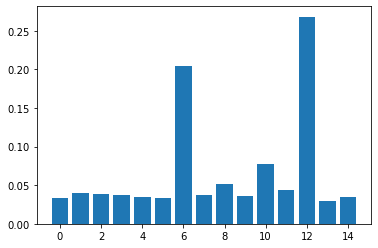

In [10]:
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.show()

In [11]:
np.argsort(xgb_model.feature_importances_)

array([13,  5,  0,  4, 14,  9,  7,  3,  2,  1, 11,  8, 10,  6, 12])

# 